# Montar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importamos las librerías

In [ ]:
! pip install transformers datasets

In [ ]:
!pip install albumentations

In [ ]:
!pip install optuna

In [7]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import optuna
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import load_dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from PIL import Image
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
from IPython.display import display

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Configuración del dispositivo

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Cargamos el dataset desde las carpetas en Google Drive

In [9]:
dataset_path = "/content/drive/My Drive/TP-VPC-II"  # Establecer la ruta correcta
dataset = load_dataset("imagefolder", data_dir=dataset_path)

Resolving data files:   0%|          | 0/9994 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/992 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Información básica del dataset

In [10]:
print(dataset)
print(dataset['train'][0])  # Ejemplo del conjunto de entrenamiento

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9994
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 992
    })
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7D401C6D43A0>, 'label': 0}


Revisión de las etiquetas

In [11]:
print(dataset['train'].features['label'].names)  # Observaremos el nombre de las clases

['con_mascarilla', 'sin_mascarilla']


Verificamos el formato y la validez de las imágenes

In [12]:
def verificar_imagenes(ruta):
    errores = []
    for clase in os.listdir(ruta):
        ruta_clase = os.path.join(ruta, clase)
        if os.path.isdir(ruta_clase):
            for archivo in os.listdir(ruta_clase):
                ruta_archivo = os.path.join(ruta_clase, archivo)
                try:
                    with Image.open(ruta_archivo) as img:
                        img.verify()  # Verifica que el archivo sea válido
                except Exception as e:
                    errores.append(ruta_archivo)
    return errores

In [ ]:
# Verificamos las imágenes en cada conjunto
errores_entrenamiento = verificar_imagenes('/content/drive/MyDrive/TP-VPC-II/train')
errores_validacion = verificar_imagenes('/content/drive/MyDrive/TP-VPC-II/validation')
errores_prueba = verificar_imagenes('/content/drive/MyDrive/TP-VPC-II/test')

In [ ]:
print("Errores en entrenamiento",errores_entrenamiento)
print("Errores en validacion",errores_validacion)
print("Errores en prueba",errores_prueba)

Errores en entrenamiento []
Errores en validacion []
Errores en prueba []


**COMENTARIO**

Se verificó la validez de las imágenes de los conjuntos de entrenamiento, validación  y prueba mediante un procedimiento que aseguraba que los archivos fueran accesibles y estuvieran en formatos compatibles.

El análisis no identificó imagenes corruptas o ilegibles en ninguna de las carpetas. Esto confirma que el dataset está limpio y no requiere depuración adicional en esa etapa.

La correcta integridad de los datos asegura un inicio óptimo para el entrenamiento del modelo.

**Visualizaremos una imagen de cada clase, para asegurarnos que están bien etiquetada y que tengan una calidad razonable.**

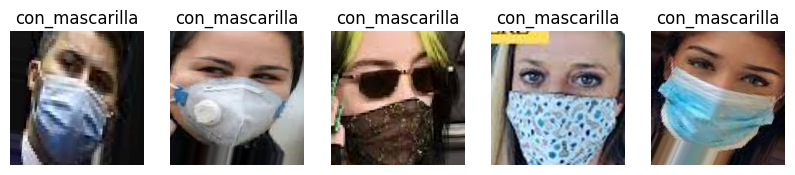

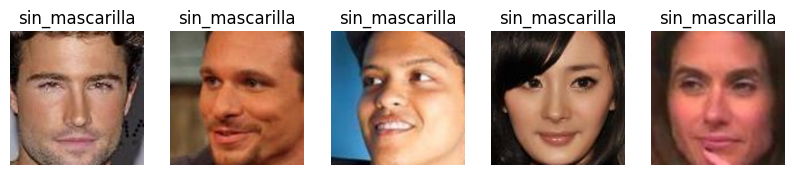

In [21]:
def mostrar_imagenes(dataset, clase):
    dataset_clase = f'/content/drive/MyDrive/TP-VPC-II/train/{clase}'
    imagenes = os.listdir(dataset_clase)
    muestras = random.sample(imagenes, 5)

    plt.figure(figsize=(10, 10))
    for i, imagen in enumerate(muestras):
        ruta_imagen = os.path.join(dataset_clase, imagen)
        img = tf.keras.utils.load_img(ruta_imagen)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(clase)
    plt.show()

mostrar_imagenes('/content/drive/MyDrive/TP-VPC-II/train', 'con_mascarilla')
mostrar_imagenes('/content/drive/MyDrive/TP-VPC-II/train', 'sin_mascarilla')

In [ ]:
def verificar_resolucion(ruta, resolucion_minima=(224, 224)):
    problemas = []
    for clase in os.listdir(ruta):
        ruta_clase = os.path.join(ruta, clase)
        if os.path.isdir(ruta_clase):
            for archivo in os.listdir(ruta_clase):
                ruta_archivo = os.path.join(ruta_clase, archivo)
                try:
                    with Image.open(ruta_archivo) as img:
                        if img.size[0] < resolucion_minima[0] or img.size[1] < resolucion_minima[1]:
                            problemas.append((ruta_archivo, img.size))
                except Exception as e:
                    print(f"Error con la imagen {ruta_archivo}: {e}")
    return problemas

# Verificar resolución en entrenamiento
problemas_resolucion = verificar_resolucion('/content/drive/MyDrive/TP-VPC-II/train')
print(f"Imágenes con resolución insuficiente: {problemas_resolucion}")

Imágenes con resolución insuficiente: []


Como podemos observar actualmente no tenemos imagenes con resolución insuficiente.

Codigo para redimensionar imagenes

In [ ]:
def redimensionar_imagenes(ruta, nueva_resolucion=(224, 224)):
    for clase in os.listdir(ruta):
        ruta_clase = os.path.join(ruta, clase)
        if os.path.isdir(ruta_clase):
            for archivo in os.listdir(ruta_clase):
                ruta_archivo = os.path.join(ruta_clase, archivo)
                try:
                    with Image.open(ruta_archivo) as img:
                        img = img.resize(nueva_resolucion)
                        img.save(ruta_archivo)
                except Exception as e:
                    print(f"No se pudo redimensionar {ruta_archivo}: {e}")

# Redimensionar imágenes en entrenamiento
redimensionar_imagenes('/content/drive/MyDrive/TP-VPC-II/train')
print("Imágenes redimensionadas correctamente.")

Imágenes redimensionadas correctamente.


Detección de Outliers en imágenes

In [ ]:
def detectar_outliers_imagenes(ruta_dataset, umbral=3):
    """
    Detecta posibles outliers en un conjunto de imágenes.

    Args:
        ruta_dataset: La ruta al directorio que contiene las imágenes.
        umbral: El número de desviaciones estándar para considerar un valor como outlier.

    Returns:
        Una lista de rutas a las imágenes que podrían ser outliers.
    """

    posibles_outliers = []

    for clase in os.listdir(ruta_dataset):
        ruta_clase = os.path.join(ruta_dataset, clase)
        if os.path.isdir(ruta_clase):
            for archivo in os.listdir(ruta_clase):
                ruta_imagen = os.path.join(ruta_clase, archivo)
                try:
                    with Image.open(ruta_imagen) as img:
                        img_array = np.array(img)

                        # Calcula la media y desviación estándar de los valores de píxeles
                        media = np.mean(img_array)
                        desviacion_estandar = np.std(img_array)

                        # Encuentra valores de píxeles que estén fuera del umbral
                        outliers = np.where(np.abs(img_array - media) > umbral * desviacion_estandar)

                        # Si hay outliers, agrega la imagen a la lista de posibles outliers
                        if len(outliers[0]) > 0:
                            posibles_outliers.append(ruta_imagen)

                except Exception as e:
                    print(f"Error con la imagen {ruta_imagen}: {e}")

    return posibles_outliers


# Ejemplo de uso
ruta_dataset = '/content/drive/MyDrive/TP-VPC-II/train'  # Ruta de mis datos de entrenamiento
posibles_outliers = detectar_outliers_imagenes(ruta_dataset,umbral =5)

print("Posibles outliers:")
for imagen in posibles_outliers:
    print(imagen)

Posibles outliers:
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_676_5077593.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_676_4687648.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_348_505066.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_365_4420617.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_505_3747869.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_505_4694065.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_298_5201201.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_298_9318750.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_298_3325075.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_266_4133371.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_348_5675938.png
/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_348_5679704.png
/content/drive/MyDrive

Despues de analizar manualmente uno a uno las imagenes que fueron considerados posibles outliers, unicamente fueron outliers las siguientes imágenes.

Clase con_mascarilla:
*   Augmented_365_4420617.png
*   Augmented_266_4133371.png
*   1533.png ("Deberia estar en la clases sin_mascarilla")
*   Augmented_13_84296.png
*   Augmented_163_4056851.png

Clase sin_mascarilla:
*   4819.png

Función para eliminar los outliers

In [ ]:
def eliminar_imagen_especifica(ruta_imagen):
  """Elimina una imagen específica dada su ruta.

  Args:
      ruta_imagen: La ruta completa a la imagen que se va a eliminar.
  """
  try:
    os.remove(ruta_imagen)
    print(f"Imagen eliminada: {ruta_imagen}")
  except FileNotFoundError:
    print(f"Error: Imagen no encontrada en la ruta {ruta_imagen}")
  except Exception as e:
    print(f"Error al eliminar la imagen {ruta_imagen}: {e}")

Eliminamos los outliers

In [ ]:
rutas_a_eliminar = [
  "/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_365_4420617.png",
  "/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_266_4133371.png",
  "/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/1533.png",
  "/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_13_84296.png",
  "/content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_163_4056851.png",
  "/content/drive/MyDrive/TP-VPC-II/train/sin_mascarilla/4819.png"
]

for ruta in rutas_a_eliminar:
  eliminar_imagen_especifica(ruta)

Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_365_4420617.png
Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_266_4133371.png
Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/1533.png
Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_13_84296.png
Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/con_mascarilla/Augmented_163_4056851.png
Imagen eliminada: /content/drive/MyDrive/TP-VPC-II/train/sin_mascarilla/4819.png


# Preparamos el Feature Extractor

In [69]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Aumento de datos con albumentations

In [70]:
transform = A.Compose([
    A.HorizontalFlip(p=0.05),# Volteo horizontal aleatorio
    A.RandomBrightnessContrast(p=0.05),# Ajustes de brillo y contraste
    A.ShiftScaleRotate(p=0.2) # Rotaciones, escalados y traslaciones
])


Función de preprocesamiento

In [71]:
def preprocess_images(examples):
    images = examples["image"]

    # Aplica las transformaciones a cada imagen
    transformed_images = [transform(image=np.array(img))["image"] for img in images]

    # Convierte las imágenes transformadas a formato PIL
    transformed_images = [Image.fromarray(img) for img in transformed_images]

    inputs = feature_extractor(transformed_images, return_tensors="pt", padding=True)
    inputs["label"] = examples["label"]
    return inputs

In [72]:
#def preprocess_images(examples):
    #images = examples["image"]

    #inputs = feature_extractor(images, return_tensors="pt", padding=True)
    #inputs["label"] = examples["label"]
    #return inputs

Pre-procesar el dataset

In [73]:
prepared_dataset = dataset.with_transform(preprocess_images)

Cargamos el modelo pre-entrenado

In [74]:
labels = dataset['train'].features['label'].names  # Extraer nombres de las clases
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label={i: label for i, label in enumerate(labels)},
    label2id={label: i for i, label in enumerate(labels)}
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

 Definir métricas adicionales

In [75]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular métricas
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Configurar argumentos de entrenamiento

In [76]:
training_args = TrainingArguments(
    output_dir="./results",          # Carpeta para resultados
    evaluation_strategy="epoch",     # realizar evaluaciones durante el entrenamiento
    save_strategy="epoch",           # Guardar modelo cada ciertos pasos
    save_steps=1000,                 # Guardar el modelo cada 1000 pasos
    learning_rate=1e-4,              # Tasa de aprendizaje ajustada
    per_device_train_batch_size=4,   # Reducir el tamaño del batch de entrenamiento
    per_device_eval_batch_size=4,    # Reducir el tamaño del batch de evaluación
    num_train_epochs=5,              # número de épocas
    weight_decay=0.01,               # Regularización L2
    logging_dir="./logs",            # Carpeta para logs
    logging_steps=200,               # Registrar logs cada 200 pasos
    load_best_model_at_end=True,    # Load the best model at the end # Changed the comment to match the value you intend
    save_total_limit=1,              # Guardar solo el último checkpoint
    remove_unused_columns=False,     # Evitar eliminar columnas no estándar
    fp16=True                        # Habilitar entrenamiento en 16 bits (si tu GPU lo soporta)
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Configuramos el trainer

In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-77-03bafe2a6384>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamos el modelo

In [78]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.042500,0.013656,0.997500,0.995025,1.000000,0.997506
2,0.000200,0.000099,1.000000,1.000000,1.000000,1.000000
3,0.025400,0.021128,0.996250,1.000000,0.992500,0.996236
4,0.000000,0.000017,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000013,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/usr/loc

TrainOutput(global_step=12495, training_loss=0.01161638550302323, metrics={'train_runtime': 3534.2073, 'train_samples_per_second': 14.139, 'train_steps_per_second': 3.535, 'total_flos': 3.872274721041162e+18, 'train_loss': 0.01161638550302323, 'epoch': 5.0})

Evaluamos el modelo en el conjunto de prueba

In [79]:
eval_results = trainer.evaluate(prepared_dataset["test"])
print("Resultados en el conjunto de prueba:", eval_results)

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Resultados en el conjunto de prueba: {'eval_loss': 0.021749192848801613, 'eval_accuracy': 0.9969758064516129, 'eval_precision': 0.9980314960629921, 'eval_recall': 0.9960707269155207, 'eval_f1': 0.9970501474926253, 'eval_runtime': 830.5374, 'eval_samples_per_second': 1.194, 'eval_steps_per_second': 0.299, 'epoch': 5.0}


Obtenemos predicciones en el conjunto de prueba

In [80]:
predictions = trainer.predict(prepared_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Calculamos la matriz de confusión

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

Visualizamos la matriz de confusión

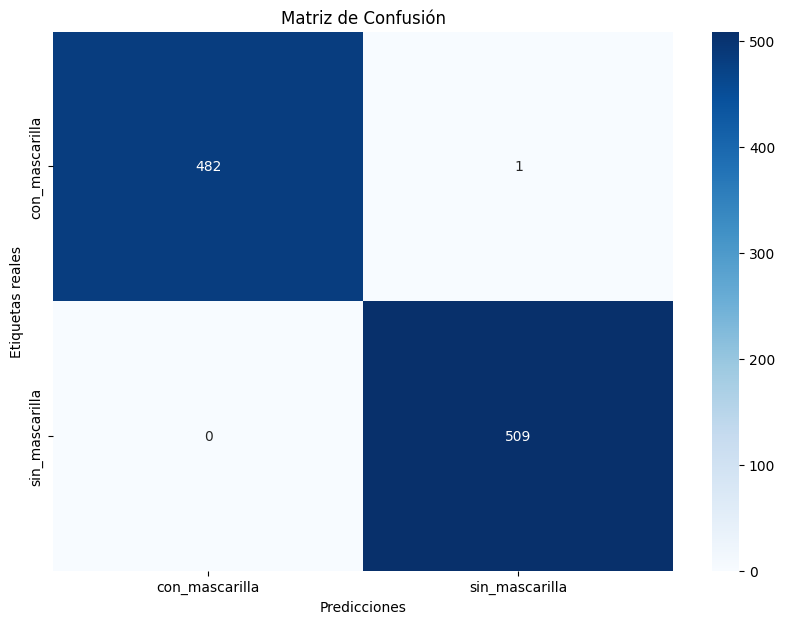

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas reales")
plt.title("Matriz de Confusión")
plt.show()

Guardamos el modelo

In [ ]:
model.save_pretrained("./mask-classifier-vit")
feature_extractor.save_pretrained("./mask-classifier-vit")

['./mask-classifier-vit/preprocessor_config.json']

Predicción en una nueva imagen

In [ ]:
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    return labels[prediction]

Ejemplo de predicción

In [ ]:
image_path = "/content/drive/MyDrive/TP-VPC-II/test/sin_mascarilla/84.png"
print("Predicción:", predict(image_path))

Predicción: sin_mascarilla


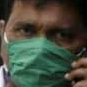

Predicción: con_mascarilla


In [ ]:
def predict(image_path):
    image = Image.open(image_path).convert("RGB")

    # Display the image
    display(image)

    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    return labels[prediction]

# Ejemplo de predicción
image_path = "/content/drive/MyDrive/TP-VPC-II/test/con_mascarilla/85.png"
print("Predicción:", predict(image_path))